
# Based on Drabas & Lee  -- Learning PySpark
## Resilient Distributed Datasets
### Data Preparation
#### Start the jupyter notebook from its own folder, otherwise python might not find some files to load!
set the kernel to python 2 or Python [default]!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')



In [2]:
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [3]:
#import findspark
#findspark.init()
#import pyspark

#from pyspark.context import SparkContext
#from pyspark.sql.session import SparkSession
#sc = SparkContext('local')
#spark = SparkSession(sc)

In [4]:
sc

<SparkContext master=spark://ec2-18-223-209-87.us-east-2.compute.amazonaws.com:7077 appName=PySparkShell>

### Duplicates

Consider the following example.

In [5]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

Check for duplicates.

In [6]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


In [7]:
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  4| 144.5|   5.9| 33|     M|
|  5| 133.2|   5.7| 54|     F|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



If these two numbers differ - you have rows that are exact copies of each other. We can drop these rows by using the `.dropDuplicates(...)` method.

In [8]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Let's confirm.

In [9]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


We still have one more duplicate. We will use the `.dropDuplicates(...)` but add the `subset` parameter.

In [10]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id'])
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



To calculate the total and distinct number of IDs in one step we can use the `.agg(...)` method.

In [11]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID. 

In [12]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



### Missing observations

Consider a similar example to the one we presented above.

In [13]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

In [14]:
df_miss.show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



To find the number of missing observations per row we can use the following snippet.

In [15]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

Let's see what values are missing so when we count missing observations in columns we can decide whether to drop the observation altogether or impute some of the observations.

In [16]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



What is the percentage of missing observations we see in each column?

In [17]:
df_miss.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the `'income'` feature as most of its values are missing.

In [18]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To drop the observations instead you can use the `.dropna(...)` method.

In [19]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To impute a mean, median or other *calculated* value you need to first calculate the value, create a dict with such values, and then pass it to the `.fillna(...)` method.

In [20]:
#!pip install --upgrade pandas

In [21]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+------------------+------+---+-------+
| id|            weight|height|age| gender|
+---+------------------+------+---+-------+
|  1|             143.5|   5.6| 28|      M|
|  2|             167.2|   5.4| 45|      M|
|  3|140.28333333333333|   5.2| 40|missing|
|  4|             144.5|   5.9| 33|      M|
|  5|             133.2|   5.7| 54|      F|
|  6|             124.1|   5.2| 40|      F|
|  7|             129.2|   5.3| 42|      M|
+---+------------------+------+---+-------+



### Outliers

Consider another simple example.

In [22]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

First, we calculate the lower and upper *cut off* points for each feature.

In [23]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

The `bounds` dictionary holds the lower and upper bounds for each feature. 

In [24]:
bounds

{'age': [-11.0, 93.0],
 'height': [4.499999999999999, 6.1000000000000005],
 'weight': [91.69999999999999, 191.7]}

Let's now use it to flag our outliers.

In [25]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



We have two outliers in the `weight` feature and two in the `age` feature.

In [26]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Understand your data

### Descriptive statistics

Load our data and convert it to a Spark DataFrame.

In [27]:
import pyspark.sql.types as typ

Next, we read the data in.

In [28]:
!pwd

/home/ec2-user/Projects/ScalableML/PySparkDemos


In [30]:
#!hdfs dfs -mkdir -p /hdfs_data
#!hdfs dfs -ls /hdfs_data
#!hdfs dfs -put data/ccFraud.csv.gz /hdfs_data
!hdfs fsck /hdfs_data/ccFraud.csv.gz

Connecting to namenode via http://ec2-18-223-209-87.us-east-2.compute.amazonaws.com:50070/fsck?ugi=ec2-user&path=%2Fhdfs_data%2FccFraud.csv.gz
FSCK started by ec2-user (auth:SIMPLE) from /172.31.5.183 for path /hdfs_data/ccFraud.csv.gz at Mon Feb 11 02:45:04 UTC 2019
.
/hdfs_data/ccFraud.csv.gz:  Under replicated BP-663532545-172.31.27.125-1549216637007:blk_1073741837_1013. Target Replicas is 3 but found 2 live replica(s), 0 decommissioned replica(s) and 0 decommissioning replica(s).
Status: HEALTHY
 Total size:	81372510 B
 Total dirs:	0
 Total files:	1
 Total symlinks:		0
 Total blocks (validated):	1 (avg. block size 81372510 B)
 Minimally replicated blocks:	1 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	1 (100.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	3
 Average block replication:	2.0
 Corrupt blocks:		0
 Missing replicas:		1 (33.333332 %)
 Number of data-nodes:		2
 Number of racks:		1
FSCK ended at Mon Feb 11 02:45:04 UTC 2019 in 

In [32]:
#fraud = sc.textFile('data/ccFraud.csv.gz')
fraud = sc.textFile('/hdfs_data/ccFraud.csv.gz')
fraud.take(3)



[u'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"',
 u'1,1,35,1,3000,4,14,2,0',
 u'2,2,2,1,0,9,0,18,0']

In [33]:
header = fraud.first()

In [34]:
header

u'"custID","gender","state","cardholder","balance","numTrans","numIntlTrans","creditLine","fraudRisk"'

In [35]:
fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

In [36]:
fraud.count()

10000000

In [37]:
fraud_sample=fraud.sample(False, 0.0001, 666)

In [38]:
fraud_sample.take(3)

[[1633, 1, 3, 1, 4000, 34, 1, 3, 0],
 [2502, 2, 36, 1, 0, 19, 9, 4, 0],
 [6452, 2, 3, 1, 6000, 10, 0, 5, 0]]

Following, we create the schema for our `DataFrame`.

In [39]:
fields=[typ.StructField(h[1:-1], typ.IntegerType(), True) for h in header.split(',')]

In [40]:
schema = typ.StructType(fields)

Finally, we create our `DataFrame`.

In [41]:
fraud_df = spark.createDataFrame(fraud_sample, schema)

Now that the dataframe is ready we can calculate the basic descriptive statistics for our dataset. 

In [42]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



For categorical columns we will count the frequencies of their values using `.groupby(...)` method.

In [43]:
fraud_df.groupby('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     1|  671|
|     2|  397|
+------+-----+



For the truly numerical features we can use the `.describe()` method.

In [44]:
numerical = ['balance', 'numTrans', 'numIntlTrans']

In [45]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+------------------+
|summary|          balance|          numTrans|      numIntlTrans|
+-------+-----------------+------------------+------------------+
|  count|             1068|              1068|              1068|
|   mean|4282.779026217228|28.428838951310862|3.7059925093632957|
| stddev|3925.359426812121|27.122506480568365| 7.689601643014246|
|    min|                0|                 1|                 0|
|    max|            20830|               100|                60|
+-------+-----------------+------------------+------------------+



Here's how you check skewness (we will do it for the `'balance'` feature only).

In [46]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|0.9402521566729165|
+------------------+



### Correlations

Calculating correlations in PySpark is very easy once your data is in a DataFrame form.

In [47]:
fraud_df.corr('balance', 'numTrans')

0.013675711968264533

In order to create a correlations matrix you can use the script below.

In [48]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

[[1.0, 0.013675711968264533, -0.019134164950994178],
 [None, 1.0, -0.0151587231508088],
 [None, None, 1.0]]

### Histograms

Aggreagate the data in workers and return aggregated list of cut-off points and counts in each bin of the histogram to the driver.

In [49]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

To plot the histogram you can simply call the matplotlib like below.

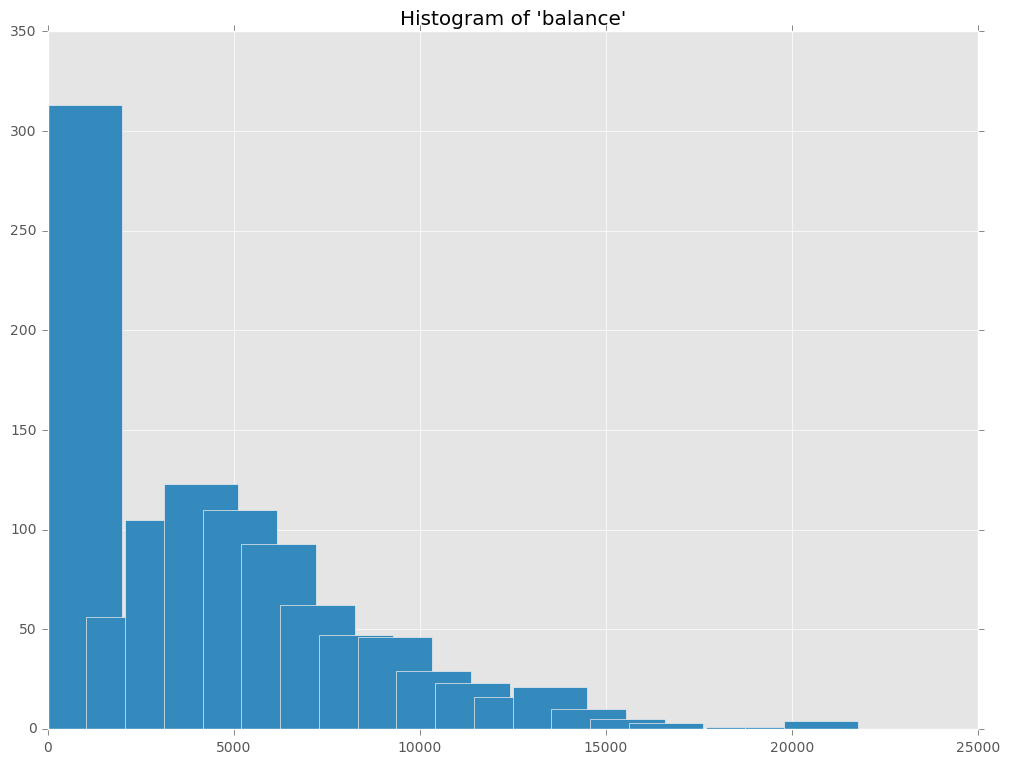

In [50]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'balance\'')

#plt.savefig('B05793_05_22.png', dpi=300)

In [51]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}

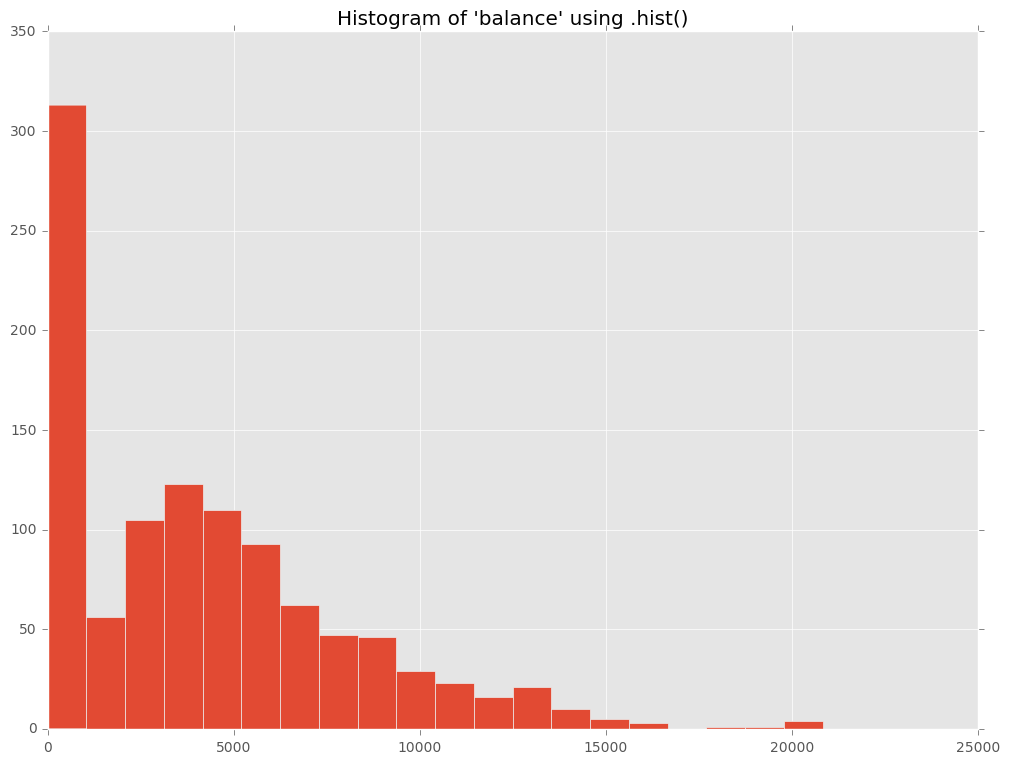

In [52]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20)
ax.set_title('Histogram of \'balance\' using .hist()')


#plt.savefig('B05793_05_24.png', dpi=300)